In [2]:
import progressbar
import h5py
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import pytz
import warnings
import pylab as plt
%matplotlib inline
from matplotlib.colors import LogNorm

import search_dispersion_events 
import importlib
importlib.reload(search_dispersion_events)

<module 'search_dispersion_events' from '/mnt/c/Users/dedasilv/OneDrive - NASA/Desktop/dmsp_data/search_dispersion_events.py'>

In [3]:
df = pd.read_csv('data/train.csv', parse_dates=['start_time', 'end_time'])
df.head()

,class,filename,sat,date,start_time,end_time
0,0,data/2015/12/21/dms_20151221_16e.001.hdf5,16,2015-12-21,2015-12-21 09:16:00+00:00,2015-12-21 09:18:00+00:00
1,1,data/2015/12/20/dms_20151220_19e.001.hdf5,19,2015-12-20,2015-12-20 04:05:00+00:00,2015-12-20 04:07:00+00:00
2,0,data/2015/03/17/dms_20150317_18e.001.hdf5,18,2015-03-17,2015-03-17 11:13:00+00:00,2015-03-17 11:18:00+00:00
3,0,data/2011/08/06/dms_20110806_16e.001.hdf5,16,2011-08-06,2011-08-06 11:02:00+00:00,2011-08-06 11:06:00+00:00
4,0,data/2015/12/20/dms_20151220_18e.001.hdf5,18,2015-12-20,2015-12-20 05:56:00+00:00,2015-12-20 05:58:00+00:00


In [50]:
def visualize(row, plot=True):
    importlib.reload(search_dispersion_events)
    
    # Do computation --------------------------------------------------
    fh = search_dispersion_events.read_file(row.filename)

    dEicdt_smooth, Eic = search_dispersion_events.estimate_log_Eic_smooth_derivative(fh)

    df_match, integrand,integral, upper_area_frac = search_dispersion_events.walk_and_integrate(
        fh, dEicdt_smooth, Eic, search_dispersion_events.DEFAULT_INTERVAL_LENGTH,
        return_integrand=True
    )
    
    if not plot:
        return df_match
    
    # Do plotting --------------------------------------------------
    i = fh['t'].searchsorted(row.start_time)
    j = fh['t'].searchsorted(row.end_time)
    
    fig, axes = plt.subplots(5, 1, figsize=(18, 16), sharex=True)

    im = axes[0].pcolor(fh['t'][i:j], np.log10(fh['ch_energy']), fh['ion_d_ener'][:, i:j], 
                        norm=LogNorm(vmin=1e3, vmax=1e8), cmap='jet')
    plt.colorbar(im, ax=axes[0]).set_label('Log Energy Flux')
    plt.colorbar(im, ax=axes[1]).set_label('')
    plt.colorbar(im, ax=axes[2]).set_label('')
    plt.colorbar(im, ax=axes[3]).set_label('')
    plt.colorbar(im, ax=axes[4]).set_label('')

    axes[0].plot(fh['t'][i:j], Eic[i:j], 'b*-')
    axes[0].invert_yaxis()
    axes[0].set_ylabel('Log Energy [eV] - Ions')

    time_length = row.end_time - row.start_time
    fig.suptitle(f'{time_length.total_seconds() / 60:.1f} minutes : '
                 f'{row.start_time.isoformat()} - {row.end_time.isoformat()}', fontweight='bold')

    title = 'MLAT = (%.1f deg to %.1f deg)' % (fh['mlat'][i], fh['mlat'][j])
    title += ' Northward' if fh['mlat'][j] > fh['mlat'][i] else ' Southward'
    title += f' -- Integral {float(integral[i:j].max()):.2f} -- UpperFrac {float(upper_area_frac[i:j].max()):.2f}'
    axes[0].set_title(title)

    axes[1].fill_between(fh['t'][i:j], 0, integrand[i:j])
    axes[1].axhline(0, color='black', linestyle='dashed')
    axes[1].set_ylim([-.25, .25])
    axes[1].set_ylabel('D(t) [eV/s]')

    axes[2].plot(fh['t'][i:j], np.log10(fh['density'][i:j]+.01), color='black')
    axes[2].set_ylabel('Log Density')
    axes[2].axhline(search_dispersion_events.DEFAULT_DENSITY_LOG_THRESHOLD, color='red', linestyle='dashed')
    axes[2].set_ylim([-2, 10])
    
    axes[3].plot(fh['t'][i:j], fh['peak_flux'][i:j])
    axes[3].set_ylabel('Peak Flux')
    axes[3].set_yscale('log')
#    axes[3].axhline(search_dispersion_events.DEFAULT_DENSITY_LOG_THRESHOLD, color='red', linestyle='dashed')
#    axes[3].set_ylim([-2, 10])

        
    en_inds = np.log10(fh['ch_energy']).searchsorted(Eic[i:j])
    en_inds = [min(i, 18) for i in en_inds]
    flux_at_Eic = fh['ion_d_ener'][en_inds, np.arange(i,j)]
    flux_at_Eic[np.isnan(Eic[i:j])] = np.nan
    
    axes[4].plot(fh['t'][i:j], flux_at_Eic, color='purple')
    axes[4].set_ylabel('Flux at Eic')
    axes[4].set_yscale('log')
    axes[4].axhline(10**6, color='red', linestyle='dashed')
    
    return df_match

N/A% (0 of 86399) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--/mnt/c/Users/dedasilv/OneDrive - NASA/Desktop/dmsp_data/search_dispersion_events.py:241: RuntimeWarning: invalid value encountered in greater
  flux_at_Eic_mask = (np.isfinite(flux_at_Eic) & (flux_at_Eic > DEFAULT_FLUX_AT_EIC_THRESHOLD)).astype(int)
100% (86399 of 86399) |##################| Elapsed Time: 0:00:06 Time:  0:00:06


,start_time,end_time,integral_min,integral_mean,integral_max,integrand_min,integrand_mean,integrand_max
0,2015-12-20 00:32:13+00:00,2015-12-20 00:34:08+00:00,0.605924,0.867440,1.099918,-0.018148,0.014702,0.057498
1,2015-12-20 00:40:36+00:00,2015-12-20 00:41:46+00:00,0.600023,0.688945,0.733444,-0.045500,0.011677,0.078742
2,2015-12-20 02:15:42+00:00,2015-12-20 02:16:46+00:00,0.638535,0.659756,0.671888,-0.030308,0.011182,0.057577
3,2015-12-20 02:22:54+00:00,2015-12-20 02:24:02+00:00,0.606069,0.668100,0.721138,-0.018217,0.011324,0.042444
4,2015-12-20 03:12:18+00:00,2015-12-20 03:13:55+00:00,0.608872,0.687100,0.751294,-0.015177,0.011646,0.060601
5,2015-12-20 03:58:53+00:00,2015-12-20 04:00:52+00:00,0.632964,1.122628,1.447752,-0.057555,0.019028,0.112064
6,2015-12-20 04:05:03+00:00,2015-12-20 04:07:14+00:00,0.605494,0.803039,1.148109,-0.015118,0.013611,0.054498
7,2015-12-20 04:49:02+00:00,2015-12-20 04:50:10+00:00,0.609140,0.672447,0.742460,-0.042427,0.011397,0.090861
8,2015-12-20 04:57:23+00:00,2015-12-20 04:58:32+00:00,0.663104,0.840272,0.947927,-0.054486,0.014242,0.118087
9,2015-12-20 05:36:57+00:00,2015-12-20 05:38:05+00:00,0.639208,0.695307,0.748341,-0.081831,0.011785,0.142393


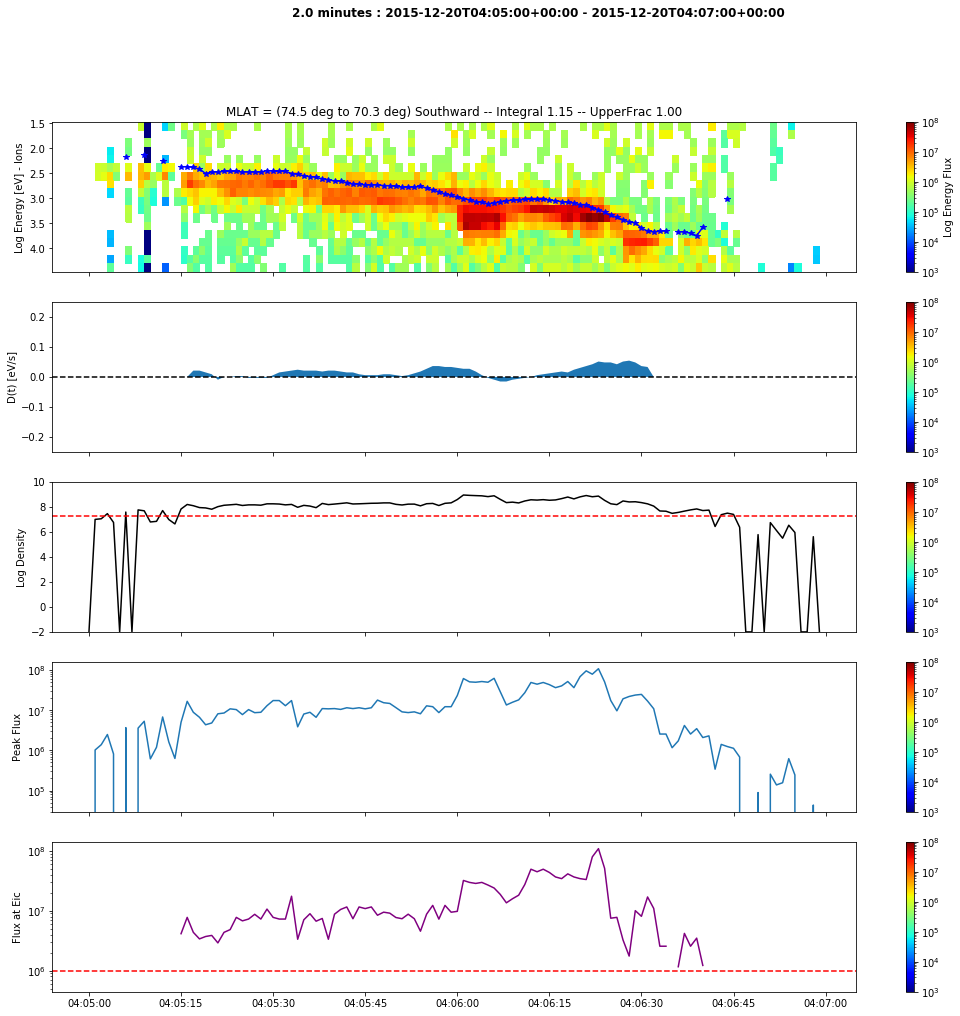

In [52]:
visualize(df[df['class']==1].iloc[0])

100% (86398 of 86398) |##################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (86399 of 86399) |##################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (86400 of 86400) |##################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (86388 of 86388) |##################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (86398 of 86398) |##################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (86397 of 86397) |##################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (86400 of 86400) |##################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (80054 of 80054) |##################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (86398 of 86398) |##################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (86399 of 86399) |##################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (86399 of 86399) |##################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (86395 of 86395) |##################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (80066 of 80066) |#################

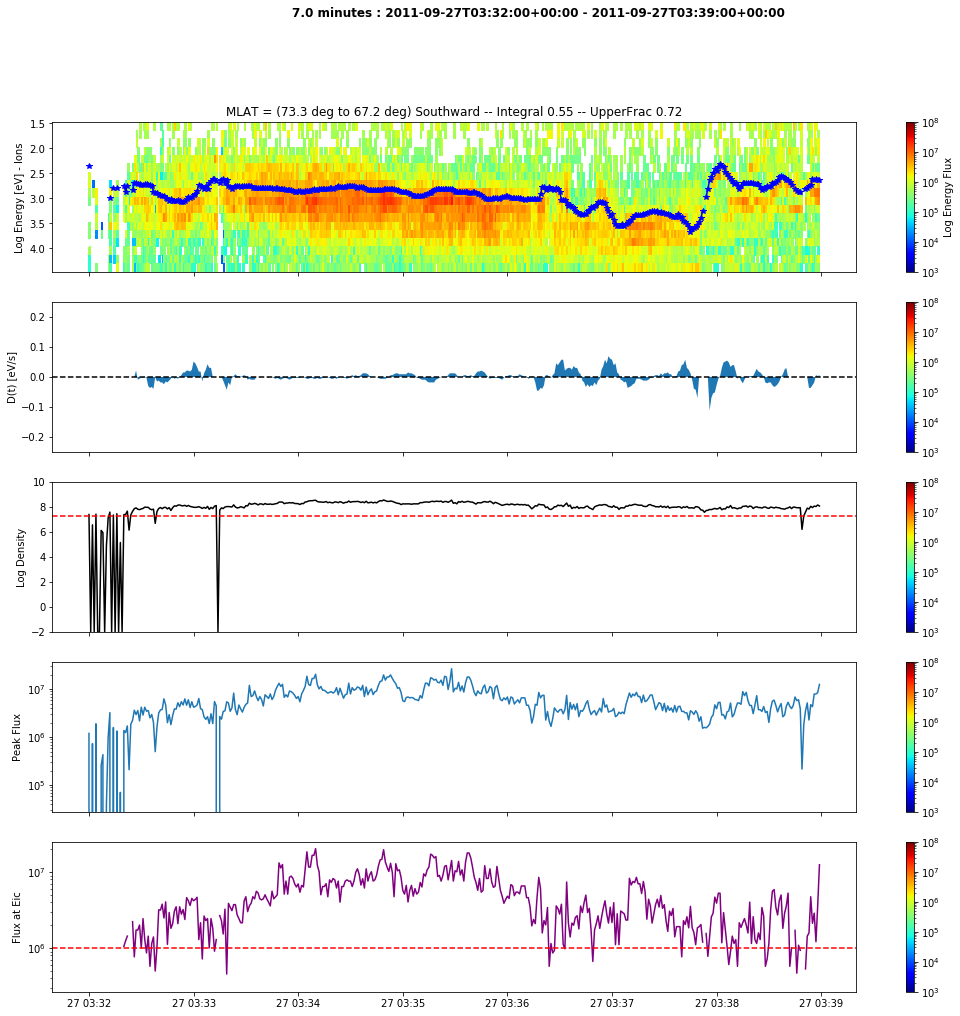

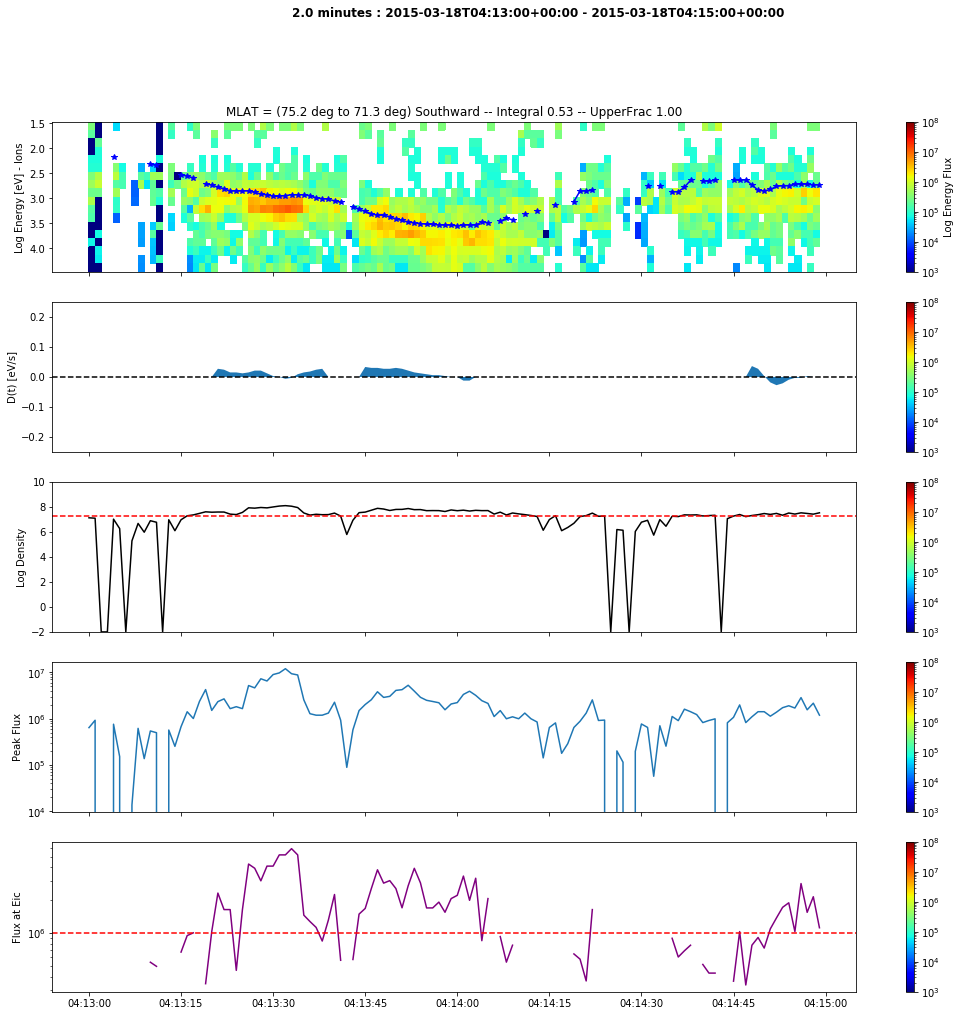

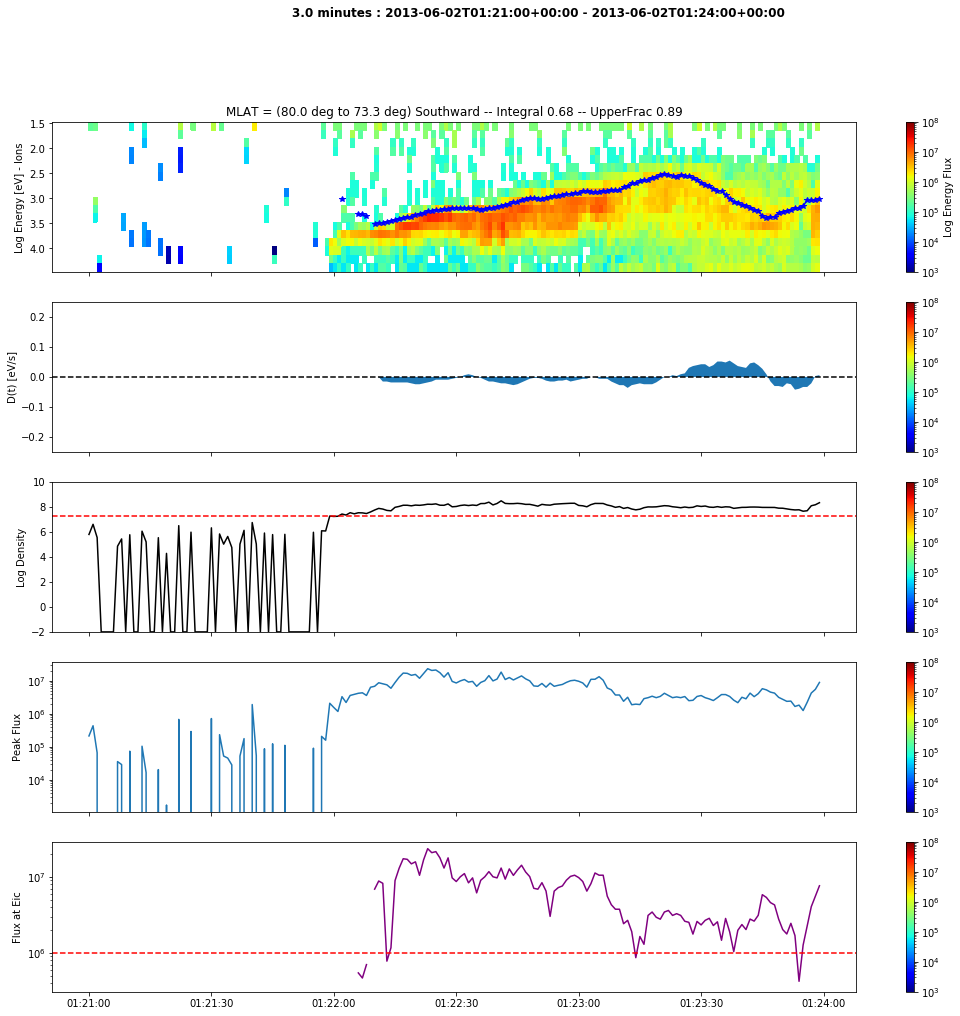

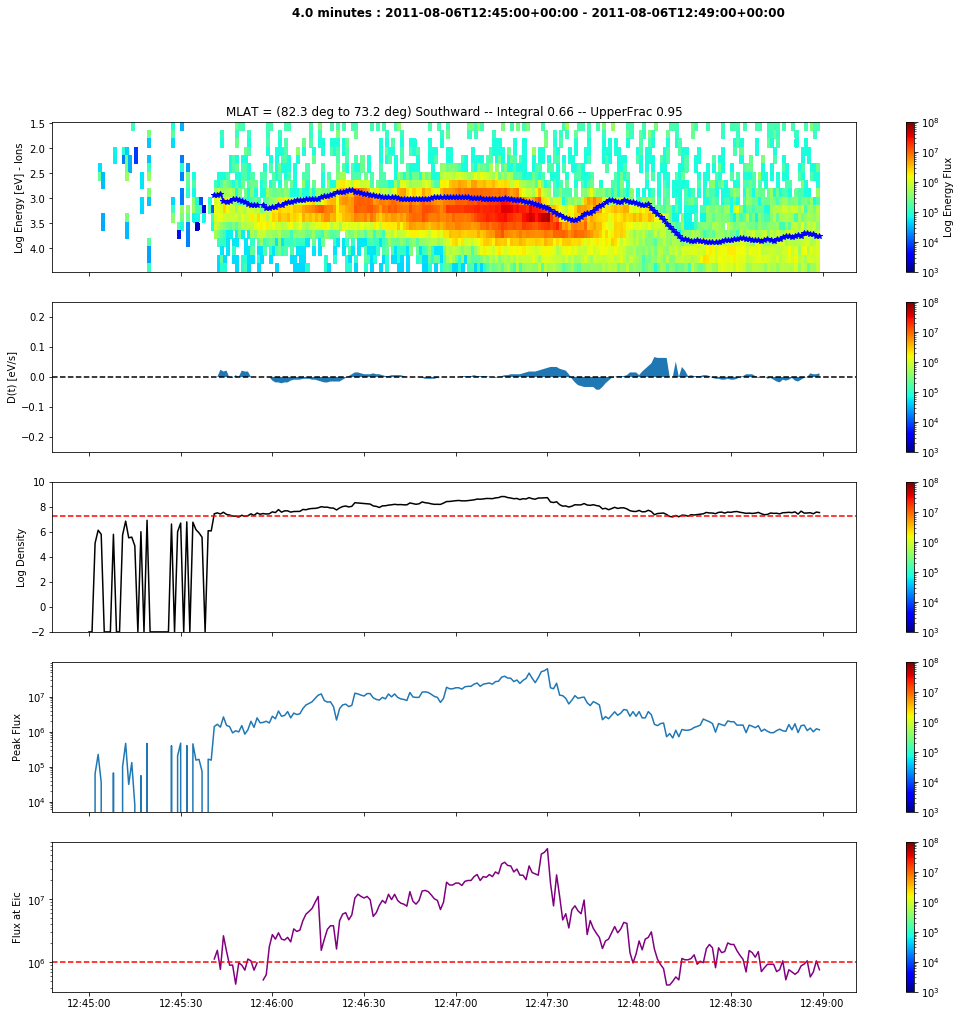

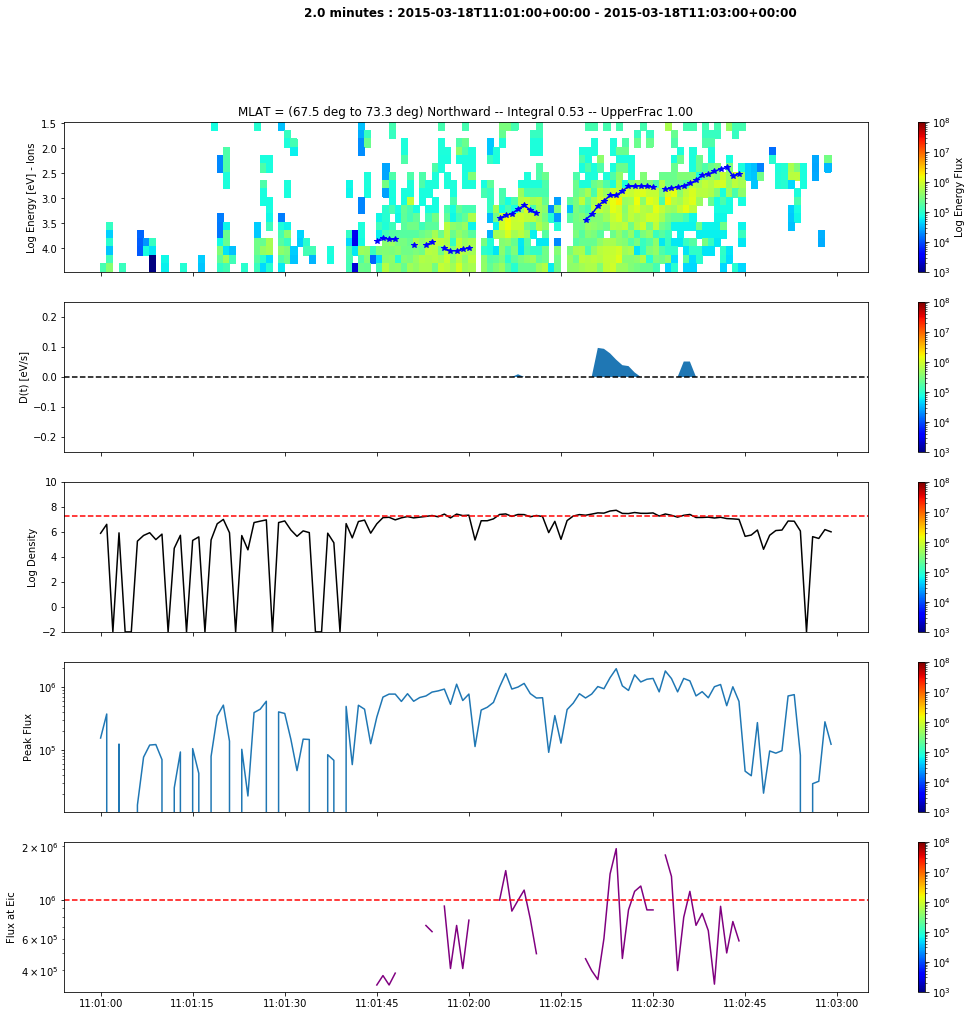

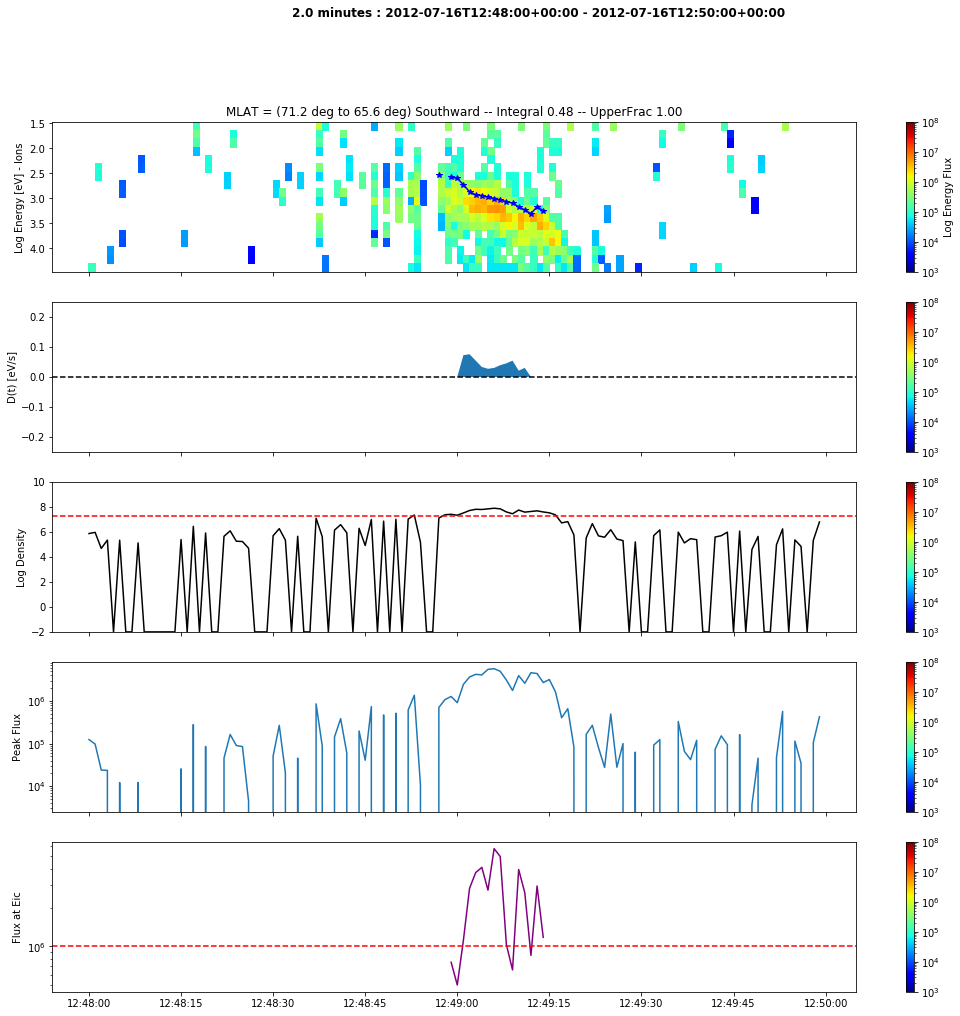

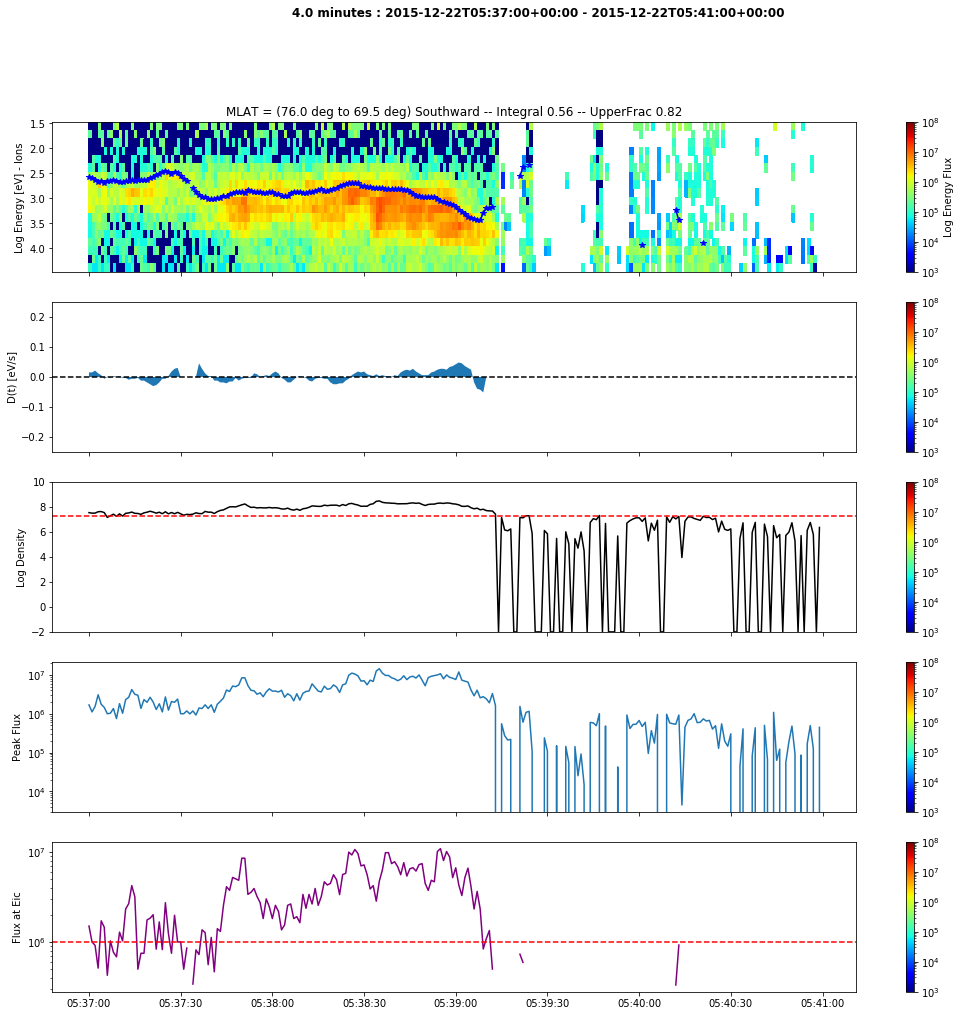

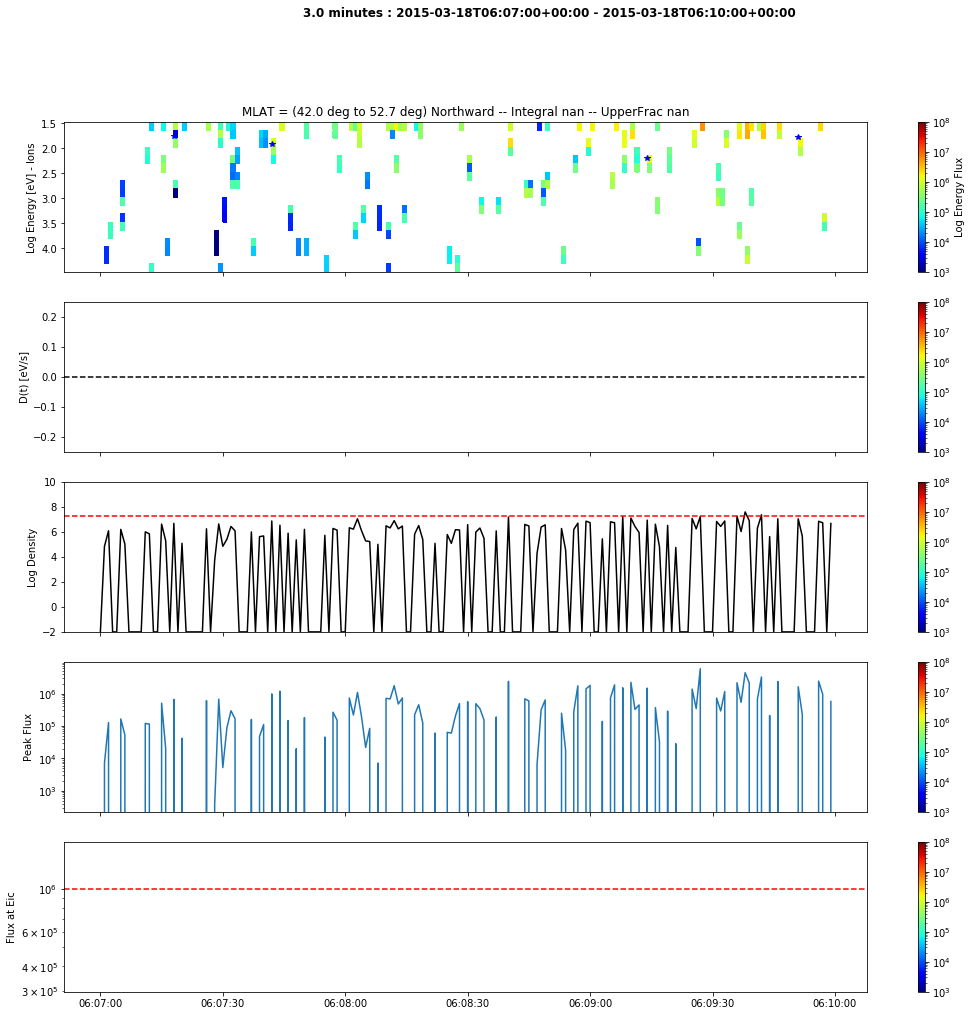

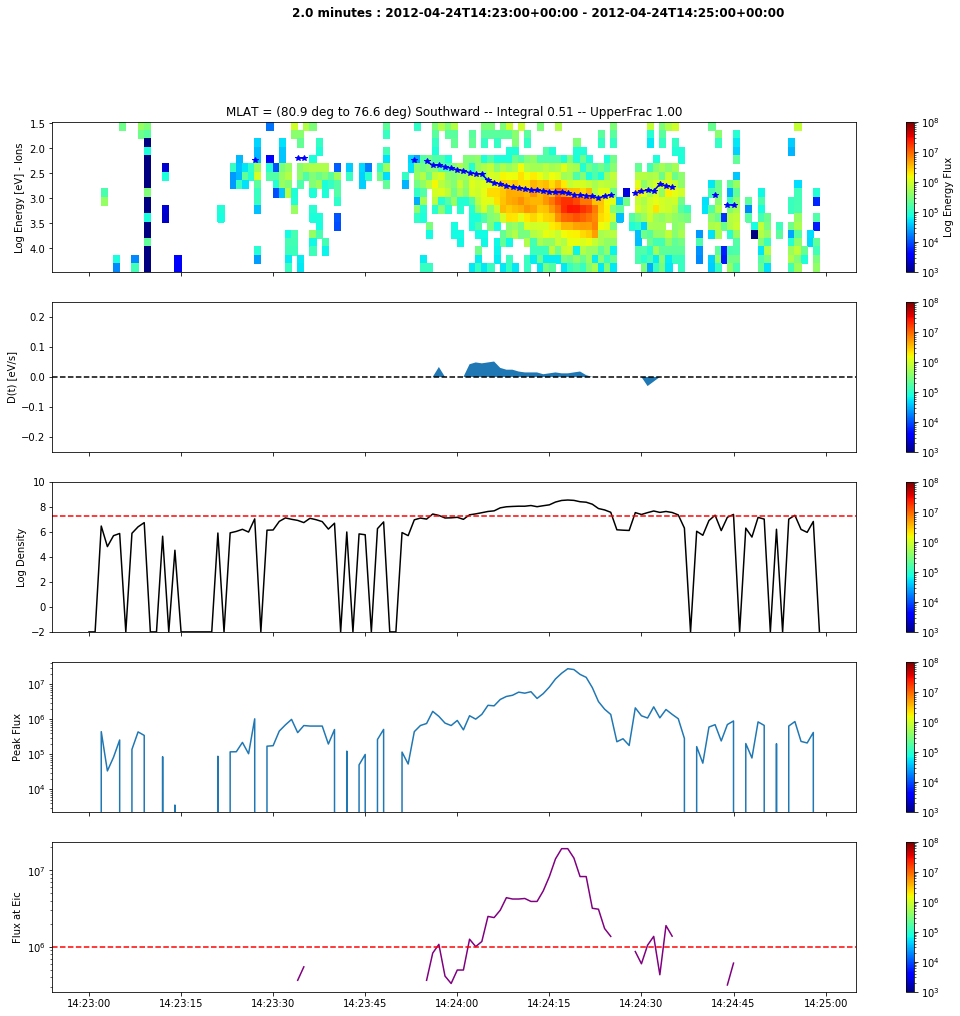

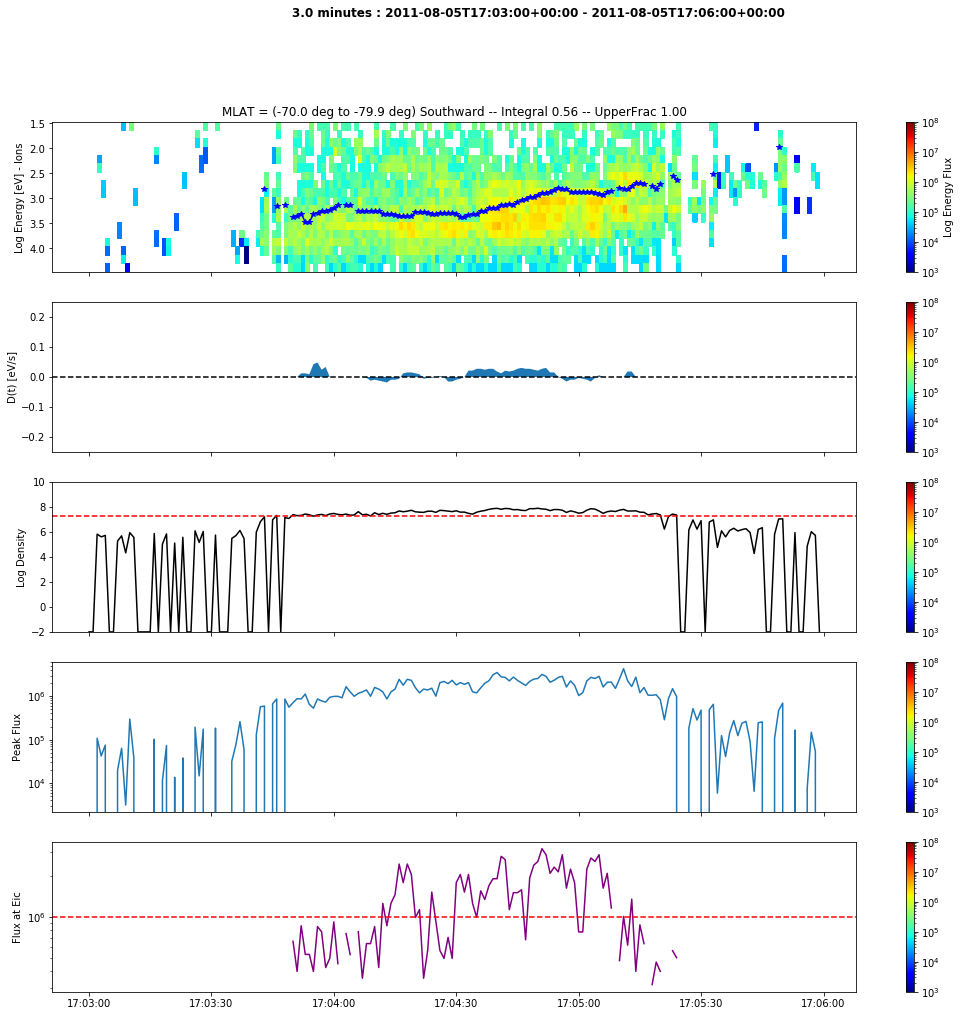

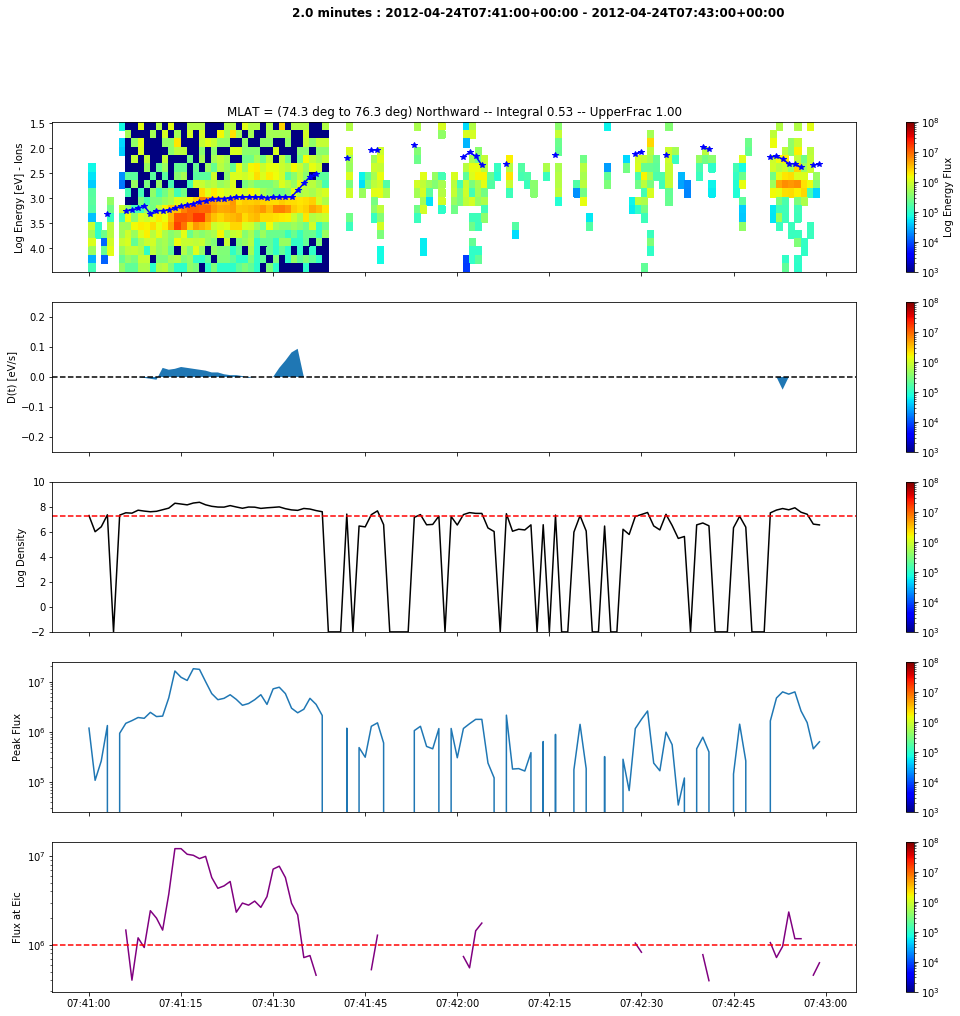

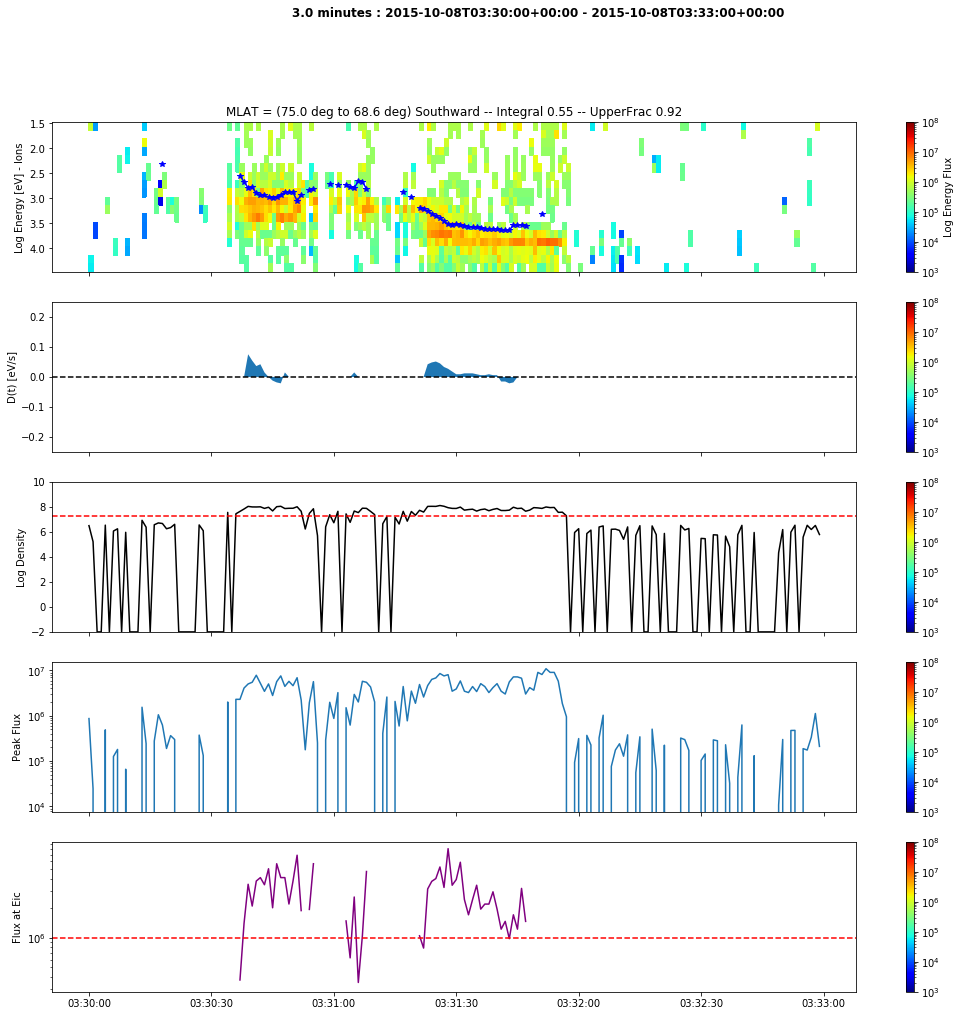

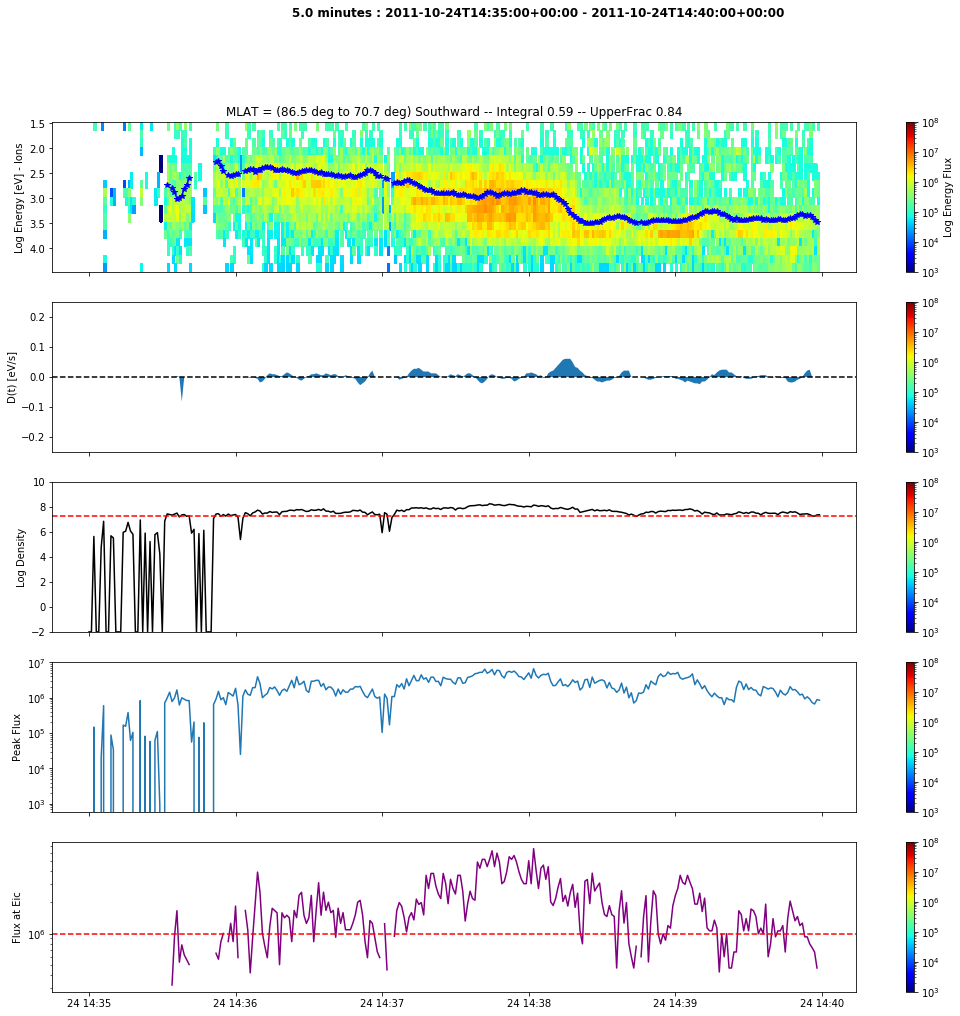

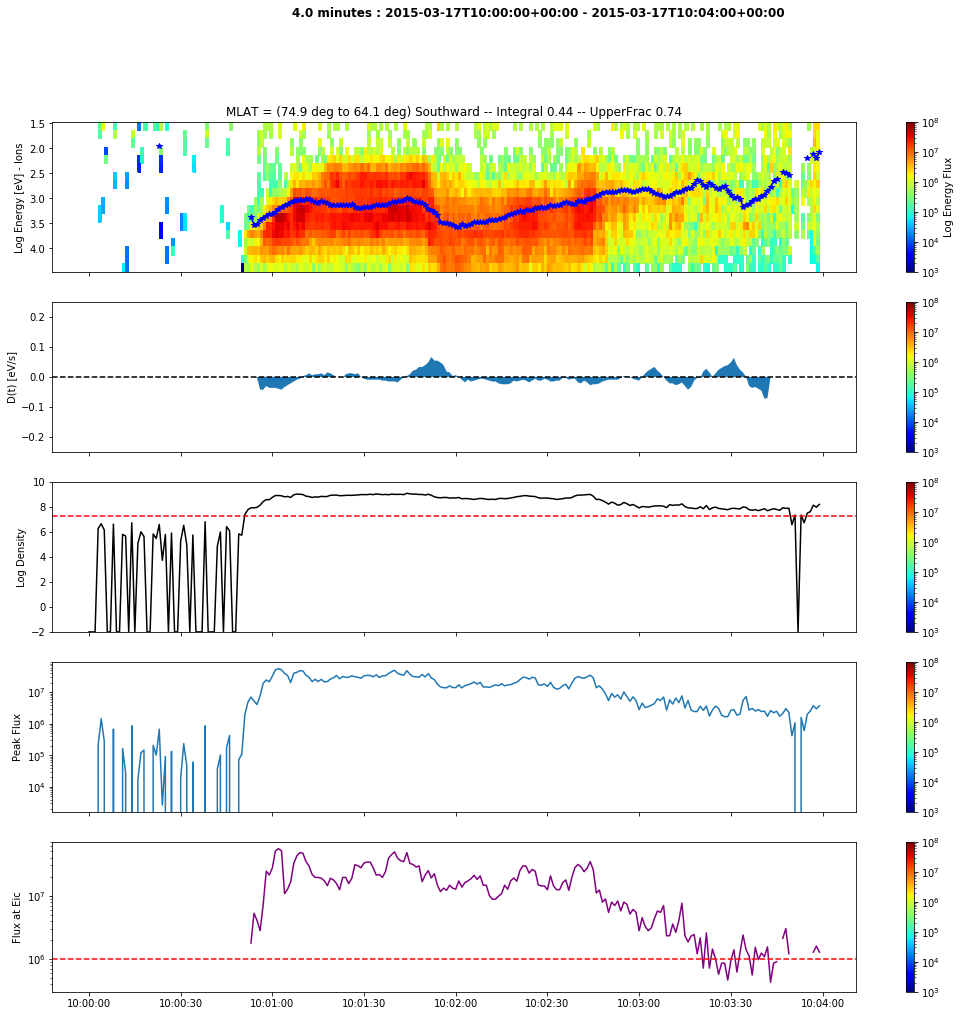

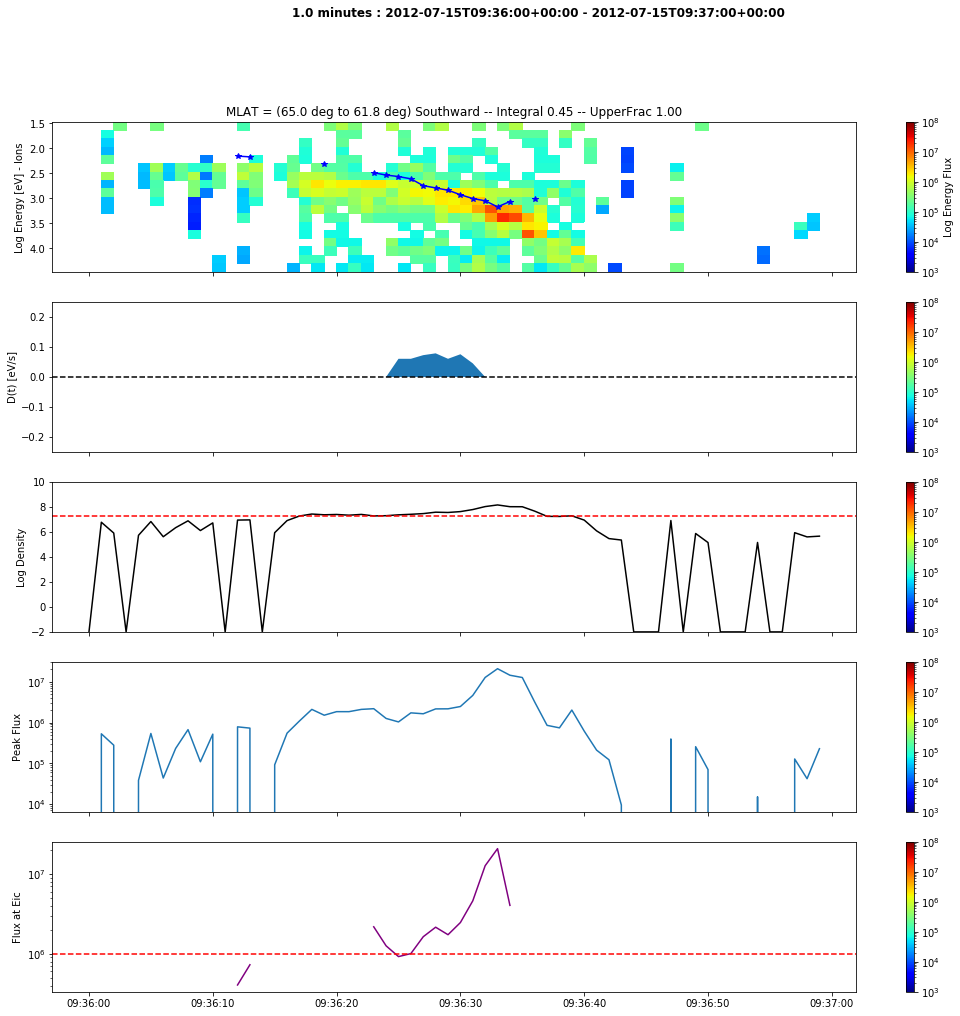

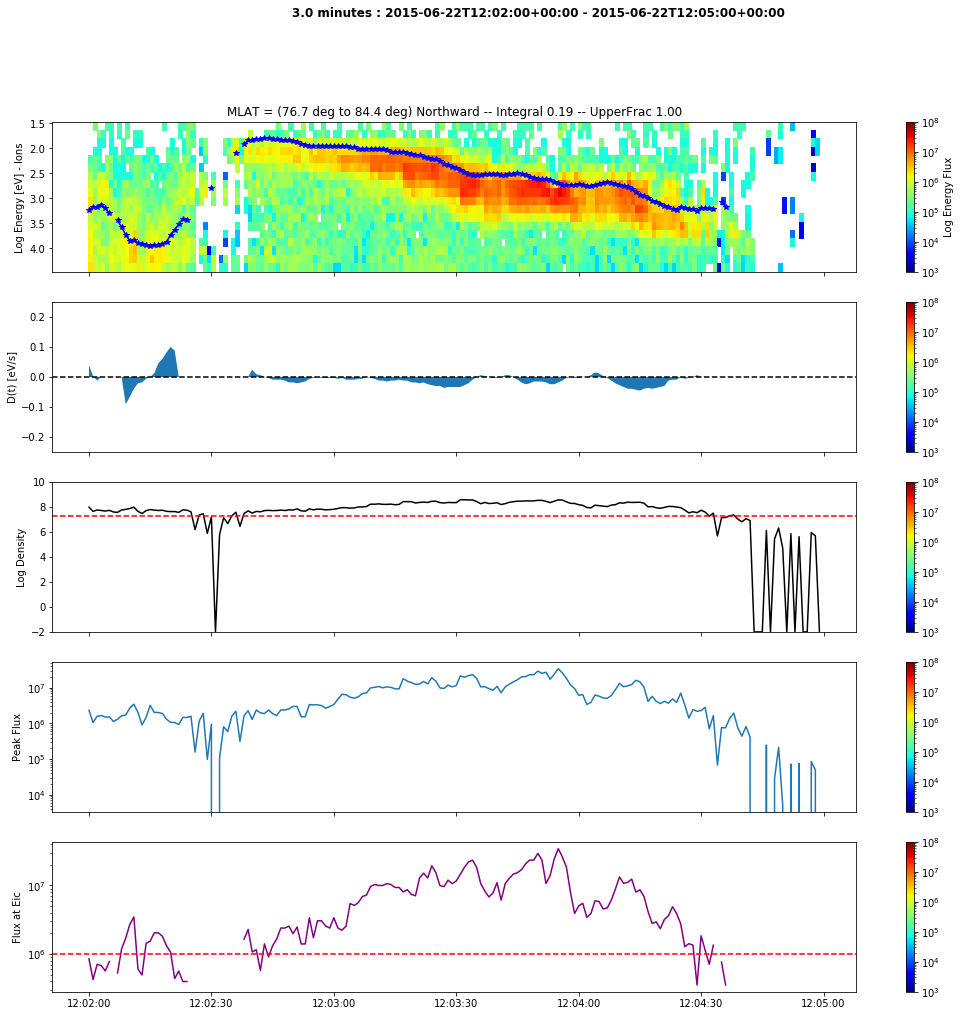

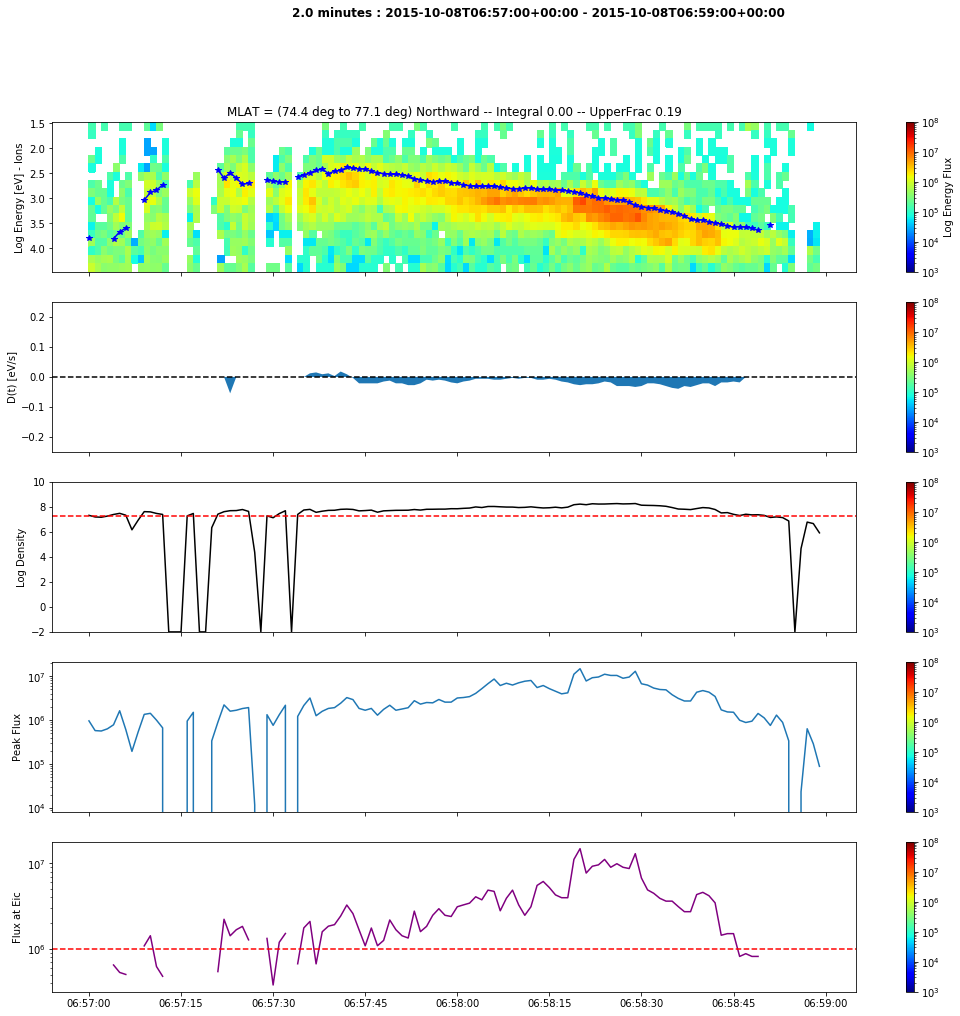

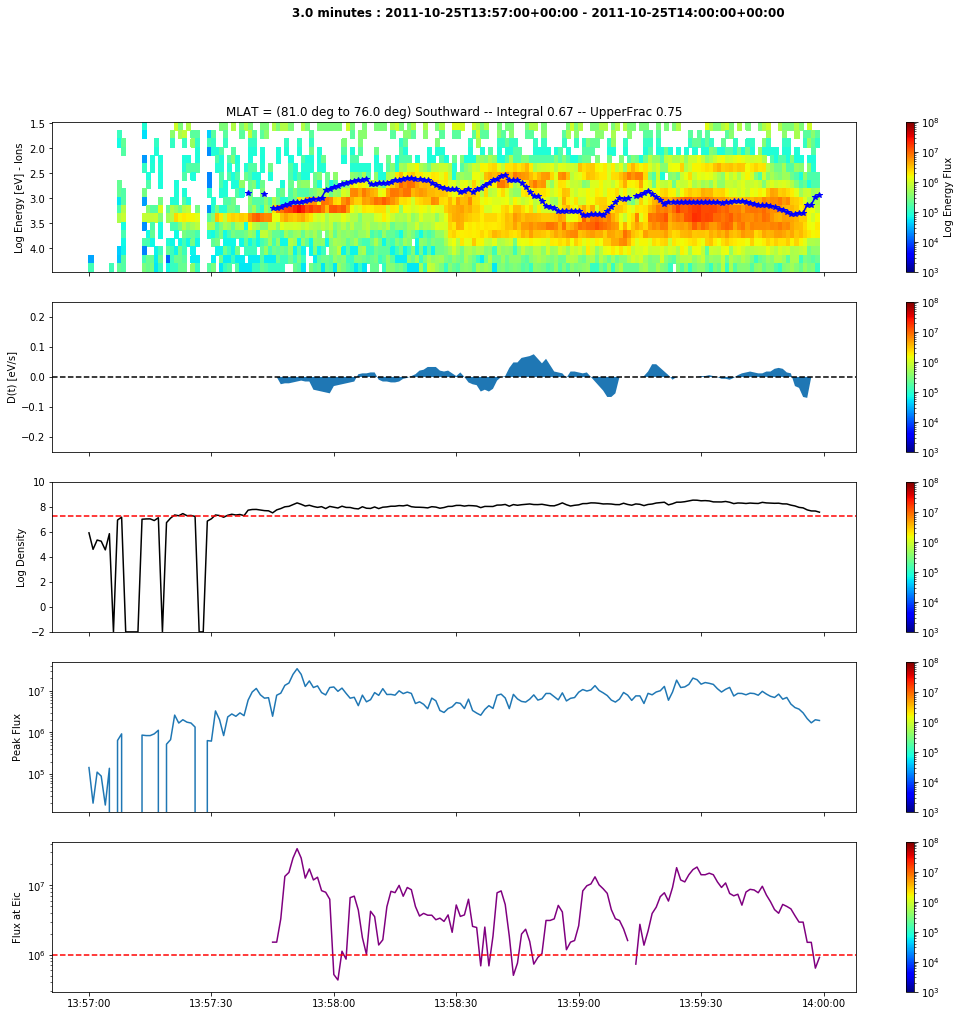

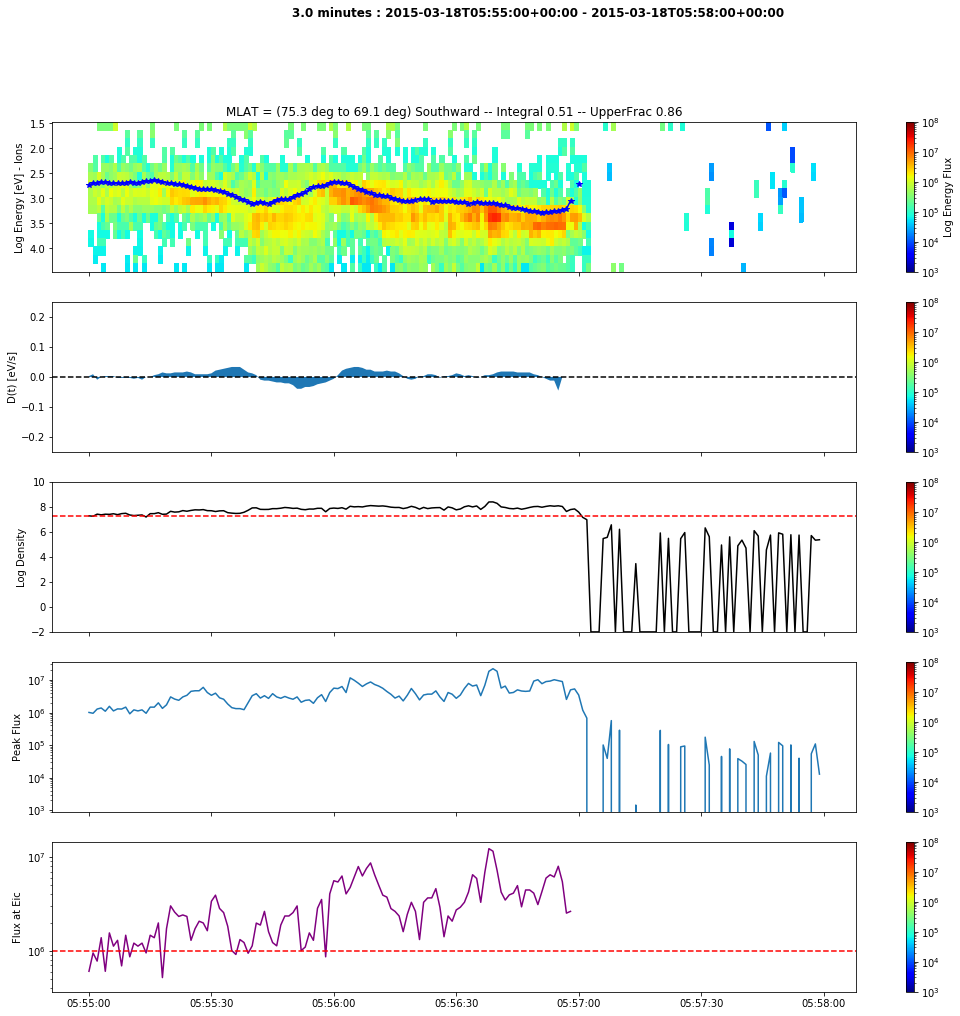

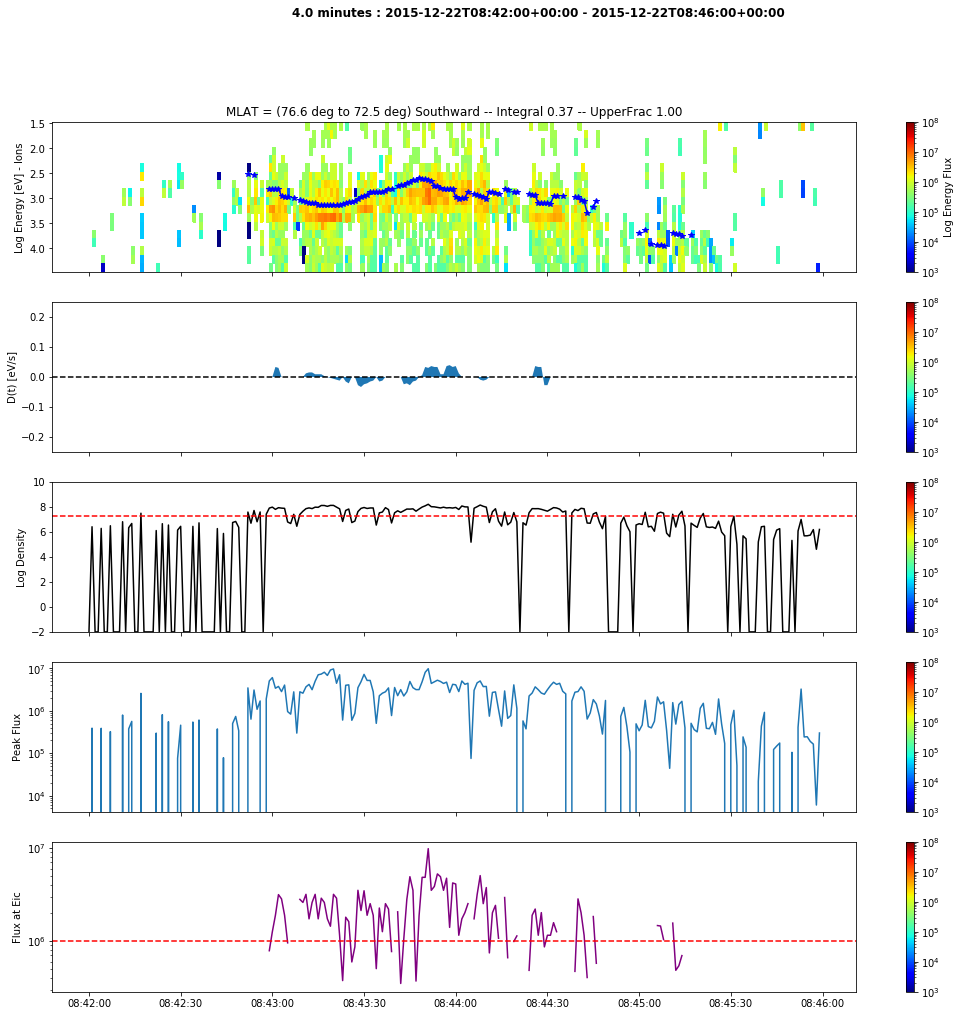

In [48]:
for i in [50, 79, 123, 146, 165, 167, 194, 200, 201, 203, 218, 220, 225, 228, 238, 246, 266, 295, 301, 304]:
    visualize(df.iloc[i])